In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [0]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [0]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [0]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [148]:
len(dataloader)

3750

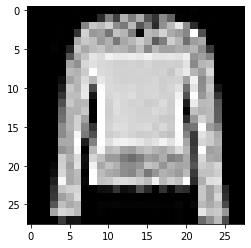

In [150]:
for image, cat in dataloader:
    plt.imshow(image[0].numpy().reshape(28, 28), cmap='gray')
    break

In [151]:
image.size()

torch.Size([16, 1, 28, 28])

In [152]:
28*28

784

### Create generator and discriminator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [0]:
generator = Generator()
discriminator = Discriminator()

In [156]:
generator.cuda()
discriminator.cuda()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Create optimizers and loss

In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [0]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28)).cuda()
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size)).cuda()
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [0]:
def train(generator, discriminator, criterion):

    input = Variable(torch.FloatTensor(config.batch_size, 28*28)).cuda()
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.FloatTensor(config.batch_size)).cuda()
    real_label = 1
    fake_label = 0
    
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
    
    
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            images = images.cuda()
            #cat = cat.cuda()
            discriminator.zero_grad()

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label.view(config.batch_size, 1))
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label.view(config.batch_size, 1))
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()

            optim_D.step()

            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label.view(config.batch_size, 1))
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()

            if (iteration+1) % config.print_freq == 0:
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
    return ERRD_x, ERRD_z, ERRG

In [164]:
criterion = nn.BCELoss()
train(generator, discriminator, criterion)

Epoch:1 Iter: 100 errD_x: 0.04 errD_z: 0.08 errG: 2.67
Epoch:1 Iter: 200 errD_x: 0.11 errD_z: 0.30 errG: 2.14
Epoch:1 Iter: 300 errD_x: 0.50 errD_z: 0.13 errG: 2.43
Epoch:1 Iter: 400 errD_x: 0.39 errD_z: 0.23 errG: 1.85
Epoch:1 Iter: 500 errD_x: 0.25 errD_z: 0.25 errG: 1.57
Epoch:1 Iter: 600 errD_x: 0.24 errD_z: 0.14 errG: 2.47
Epoch:1 Iter: 700 errD_x: 0.13 errD_z: 0.16 errG: 2.59
Epoch:1 Iter: 800 errD_x: 0.11 errD_z: 0.32 errG: 1.78
Epoch:1 Iter: 900 errD_x: 0.19 errD_z: 0.08 errG: 3.08
Epoch:1 Iter: 1000 errD_x: 0.34 errD_z: 0.05 errG: 3.57
Epoch:1 Iter: 1100 errD_x: 0.55 errD_z: 0.17 errG: 1.93
Epoch:1 Iter: 1200 errD_x: 0.45 errD_z: 0.05 errG: 2.97
Epoch:1 Iter: 1300 errD_x: 0.36 errD_z: 0.18 errG: 2.27
Epoch:1 Iter: 1400 errD_x: 0.15 errD_z: 0.18 errG: 2.97
Epoch:1 Iter: 1500 errD_x: 0.32 errD_z: 0.14 errG: 3.15
Epoch:1 Iter: 1600 errD_x: 0.20 errD_z: 0.38 errG: 2.75
Epoch:1 Iter: 1700 errD_x: 0.26 errD_z: 0.26 errG: 3.43
Epoch:1 Iter: 1800 errD_x: 0.05 errD_z: 0.50 errG: 2.49
E

(array([ 626.26314312,  652.18152499,  979.04521206,  890.887101  ,
        1233.05731866, 1149.05195467, 1484.96873987, 1443.27503555,
        1429.51620305, 1531.48089336]),
 array([480.78080823, 423.21388849, 613.66593054, 548.5783631 ,
        722.9140249 , 707.85208967, 908.46928675, 860.6708436 ,
        876.33452853, 969.13889676]),
 array([11637.66527772, 11871.93332064, 10813.11029369, 11232.51216793,
        10749.31090939, 11070.83881259, 10102.9920637 ,  9746.32901168,
         9558.29520035,  9337.18221033]))

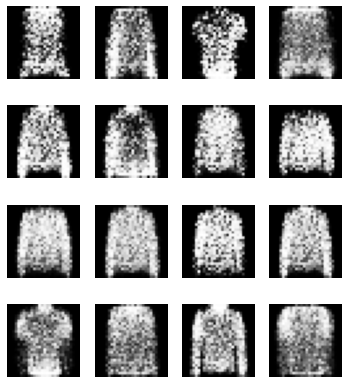

In [166]:
def make_samples(generator):
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
    noise.data.normal_(0, 1)
    fake = generator(noise)

    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
make_samples(generator)

## Задание 1

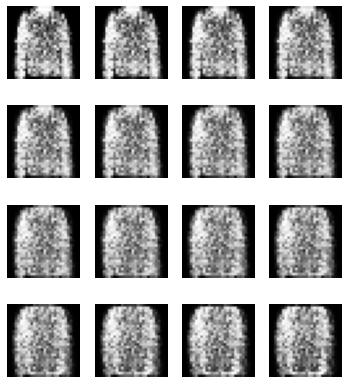

In [168]:
# Интерполяция между двумя сгенерированными картинками
noise.data.normal_(0, 1)
fake = generator(noise)
imag1 = fake[0].cpu().detach().numpy().reshape(28, 28)
imag2 = fake[1].cpu().detach().numpy().reshape(28, 28)
diff = imag1 - imag2

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imag2 + (i/15)*diff, cmap=plt.cm.Greys_r)
    plt.axis('off')

In [0]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.first_linear = nn.Linear(config.noise_size, 3*3*512)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.first_linear(x)
        x = x.view(-1, 512, 3, 3)
        x = self.model(x)
        return x
    
class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256)
        )
        self.last_linear = nn.Sequential(nn.Linear(7*7*256, 1), nn.Sigmoid())
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 7*7*256)
        return self.last_linear(x)

In [171]:
generator = DCGenerator().cuda()
discriminator = DCDiscriminator().cuda()
criterion = nn.BCELoss()
train(generator, discriminator, criterion)

Epoch:1 Iter: 100 errD_x: 0.67 errD_z: 3.46 errG: 0.03
Epoch:1 Iter: 200 errD_x: 0.52 errD_z: 2.62 errG: 0.08
Epoch:1 Iter: 300 errD_x: 0.50 errD_z: 1.79 errG: 0.19
Epoch:1 Iter: 400 errD_x: 0.58 errD_z: 1.18 errG: 0.38
Epoch:1 Iter: 500 errD_x: 0.62 errD_z: 0.88 errG: 0.55
Epoch:1 Iter: 600 errD_x: 0.59 errD_z: 0.90 errG: 0.53
Epoch:1 Iter: 700 errD_x: 0.65 errD_z: 0.87 errG: 0.55
Epoch:1 Iter: 800 errD_x: 0.67 errD_z: 0.78 errG: 0.62
Epoch:1 Iter: 900 errD_x: 0.65 errD_z: 0.69 errG: 0.71
Epoch:1 Iter: 1000 errD_x: 0.64 errD_z: 0.68 errG: 0.72
Epoch:1 Iter: 1100 errD_x: 0.64 errD_z: 0.73 errG: 0.68
Epoch:1 Iter: 1200 errD_x: 0.68 errD_z: 0.57 errG: 0.85
Epoch:1 Iter: 1300 errD_x: 0.57 errD_z: 0.61 errG: 0.80
Epoch:1 Iter: 1400 errD_x: 0.57 errD_z: 0.79 errG: 0.63
Epoch:1 Iter: 1500 errD_x: 0.53 errD_z: 0.60 errG: 0.82
Epoch:1 Iter: 1600 errD_x: 0.37 errD_z: 0.74 errG: 0.67
Epoch:1 Iter: 1700 errD_x: 0.34 errD_z: 0.69 errG: 0.72
Epoch:1 Iter: 1800 errD_x: 0.51 errD_z: 0.66 errG: 0.75
E

(array([1686.74154422,  836.90651942,  439.25465401,  294.68157973,
         628.12519821,  180.34244461,   96.72528019, 1659.29107158,
        6217.63390681, 4048.75364854]),
 array([2910.01405224,  678.89458315,  335.83514954,  210.21804135,
         250.04014849,   61.40005778,   40.04529633,  663.29890614,
        1619.3113861 ,  862.82623979]),
 array([ 3403.75060938,  7976.91021982, 10681.86265334, 12811.29379925,
        11760.66195935, 16666.50351644, 18215.53952265,  9332.8901818 ,
         5290.33373285,  7245.10010725]))

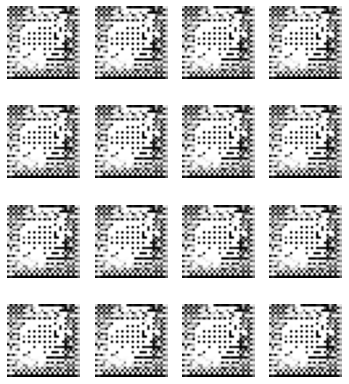

In [172]:
make_samples(generator)

## Задание 2

In [0]:
config.noise_size = 1024
false_label = 0.00001
class LSGenerator(nn.Module):
    def __init__(self):
        super(LSGenerator, self).__init__()
        self.first_linear = nn.Sequential(nn.Linear(config.noise_size, 1*1*256),
                                          nn.BatchNorm1d(1*1*256))
        self.model = nn.Sequential( 
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=6, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.first_linear(x)
        x = x.view(-1, 256, 1, 1)
        x = self.model(x)
        return x
    
class LSDiscriminator(nn.Module):
    def __init__(self):
        super(LSDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.last_linear = nn.Sequential(nn.Linear(2*2*512, 1), nn.Sigmoid())
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.model(x)
        x = x.view(-1, 2*2*512)
        return self.last_linear(x)

In [179]:
false_label = 0.00001 # обучается очень долго, поэтому оставим 4 эпохи
generator = LSGenerator().cuda()
discriminator = LSDiscriminator().cuda()
loss = nn.MSELoss()
train(generator, discriminator, loss)

Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.99
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1100 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1200 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1300 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1400 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1500 errD_x: 0.00 errD_z: 0.01 errG: 1.00
Epoch:1 Iter: 1600 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1700 errD_x: 0.00 errD_z: 0.00 errG: 1.00
Epoch:1 Iter: 1800 errD_x: 0.00 errD_z: 0.00 errG: 1.00
E

KeyboardInterrupt: ignored

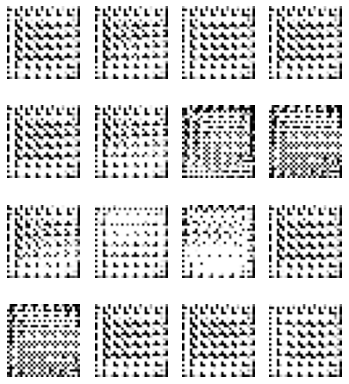

In [180]:
make_samples(generator)

## Задание 3.

In [0]:
class LSGeneratorWithCat(nn.Module):
    def __init__(self):
        super(LSGeneratorWithCat, self).__init__()
        self.first_linear = nn.Sequential(nn.Linear(50 + 10, 7*7*128),
                                          nn.BatchNorm1d(7*7*128))
    
        self.encoder = nn.Linear(1, 10)

        self.model = nn.Sequential( 
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x, cat):
        cat = cat.view(-1, 1)
        cat = self.encoder(cat)
        x = torch.cat((x, cat), dim=1)
        x = self.first_linear(x)
        x = x.view(-1, 128, 7, 7)
        x = self.model(x)
        return x
    
class LSDiscriminatorWithCat(nn.Module):
    def __init__(self):
        super(LSDiscriminatorWithCat, self).__init__()
        self.encoder = nn.Linear(1, 57)
        self.model = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 320, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(320),
        )
        self.last_linear = nn.Sequential(nn.Linear(8*8*320, 1024),
                                         nn.BatchNorm1d(1024),
                                         nn.Linear(1024, 1), nn.Sigmoid())
    def forward(self, x, cat):
        cat = cat.view(-1, 1)
        cat = self.encoder(cat)
        x = torch.cat((x.view(-1, 784), cat), dim=1)
        x = x.view(-1, 1, 29, 29)
        x = self.model(x)
        x = x.view(-1, 8*8*320)
        return self.last_linear(x)

In [211]:
generator = LSGeneratorWithCat().cuda()
discriminator = LSDiscriminatorWithCat().cuda()
    
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
criterion = nn.MSELoss()


ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        images = images.cuda()
        cat = cat.cuda().float()
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output, label.view(config.batch_size, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise, cat)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), cat)
        errD_z = criterion(output, label.view(config.batch_size, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, cat)
        errG = criterion(output, label.view(config.batch_size, 1))
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                        iteration+1, 
                                                                                        errD_x.item(),
                                                                                        errD_z.item(), 
                                                                                        errG.item()))
return ERRD_x, ERRD_z, ERRG

Epoch:1 Iter: 100 errD_x: 0.22 errD_z: 0.26 errG: 0.66
Epoch:1 Iter: 200 errD_x: 0.14 errD_z: 0.18 errG: 0.62
Epoch:1 Iter: 300 errD_x: 0.23 errD_z: 0.19 errG: 0.79
Epoch:1 Iter: 400 errD_x: 0.20 errD_z: 0.19 errG: 0.79
Epoch:1 Iter: 500 errD_x: 0.23 errD_z: 0.35 errG: 0.46
Epoch:1 Iter: 600 errD_x: 0.13 errD_z: 0.19 errG: 0.75
Epoch:1 Iter: 700 errD_x: 0.16 errD_z: 0.13 errG: 0.82
Epoch:1 Iter: 800 errD_x: 0.15 errD_z: 0.27 errG: 0.48
Epoch:1 Iter: 900 errD_x: 0.09 errD_z: 0.43 errG: 0.39
Epoch:1 Iter: 1000 errD_x: 0.06 errD_z: 0.14 errG: 0.71
Epoch:1 Iter: 1100 errD_x: 0.05 errD_z: 0.38 errG: 0.62
Epoch:1 Iter: 1200 errD_x: 0.03 errD_z: 0.19 errG: 0.81
Epoch:1 Iter: 1300 errD_x: 0.02 errD_z: 0.13 errG: 0.87
Epoch:1 Iter: 1400 errD_x: 0.02 errD_z: 0.08 errG: 0.82
Epoch:1 Iter: 1500 errD_x: 0.01 errD_z: 0.13 errG: 0.87
Epoch:1 Iter: 1600 errD_x: 0.01 errD_z: 0.19 errG: 0.81
Epoch:1 Iter: 1700 errD_x: 0.01 errD_z: 0.31 errG: 0.63
Epoch:1 Iter: 1800 errD_x: 0.01 errD_z: 0.19 errG: 0.81
E

KeyboardInterrupt: ignored

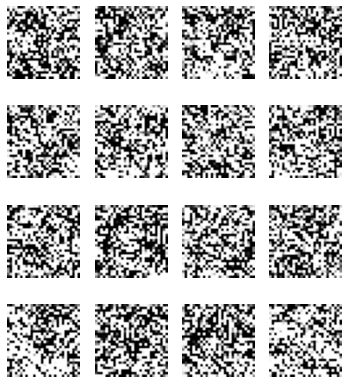

In [220]:
config.noise_size = 50
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).cuda()
noise.data.normal_(0, 1)
fake = generator(noise, torch.FloatTensor([0] * 16).cuda())

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Почему-то GAN со свертками не очень справились с задачей. В первом случае очень сложно понять, где и что пошло не так, вроде ббы графики обучения выглядят нормально. Во втором случае, наверное, дискриминатор получился слишком умным и не давал генератору обмануть себя. Это видно из того, что у дискриминатора лосс всегда 0, а у генератора - наоборот. В третьем случае также сложно понять, что именно не так. Все модели со свертками выдают лишь преобразованный шум.
Возможно, проблема в недообучении.